# Intro

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import namedtuple
from sklearn.metrics import multilabel_confusion_matrix
from collections import namedtuple
import random

def get_dataloaders(input_size=256, batch_size=4):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    shuffles = {
        'train': True,
        'test': True,
        'valid': False
    }

    data_dir = './faces'
    samples = ['train', 'test', 'valid']
    image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in samples }
    dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=shuffles[x], num_workers=4) for x in samples }
    dataset_sizes = { x: len(image_datasets[x]) for x in samples }
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names, len(class_names)

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        results = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer.step()
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            result = Result(phase, epoch_loss, float(str(epoch_acc.cpu().numpy())))
            results.append(result)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        results = ['{} loss: {:.4f} acc: {:.4f}'.format(r.phase, r.loss, r.acc) for r in results]
        results = ' | '.join(results)
        print('Epoch {}/{} | {}'.format(epoch, num_epochs - 1, results))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_metrics(model, dataloaders, class_names):
    y_true = []
    y_pred = []
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            cpu_labels = labels.cpu().numpy()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                cpu_label = f'{cpu_labels[j]:02}'
                clazz_name = class_names[preds[j]]
                
                y_true.append(cpu_label)
                y_pred.append(clazz_name)
                
                
        model.train(mode=was_training)
    
    cmatrices = multilabel_confusion_matrix(y_true, y_pred, labels=class_names)
    metrics = []
    for clazz in range(len(cmatrices)):
        cmatrix = cmatrices[clazz]
        tn, fp, fn, tp = cmatrix[0][0], cmatrix[0][1], cmatrix[1][0], cmatrix[1][1]
        sen = tp / (tp + fn)
        spe = tn / (tn + fp)
        acc = (tp + tn) / (tp + fp + fn + tn)
        f1 = (2.0 * tp) / (2 * tp + fp + fn)
        mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        metric = Metric(clazz, tn, fp, fn, tp, sen, spe, acc, f1, mcc)
        metrics.append(metric)
    
    return metrics

def print_metrics(metrics):
    for m in metrics:
        print('{}: sen = {:.5f}, spe = {:.5f}, acc = {:.5f}, f1 = {:.5f}, mcc = {:.5f}'
              .format(m.clazz, m.sen, m.spe, m.acc, m.f1, m.mcc))

random.seed(1299827)
torch.manual_seed(1299827)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device = {}'.format(device))

Result = namedtuple('Result', 'phase loss acc')
Metric = namedtuple('Metric', 'clazz tn fp fn tp sen spe acc f1 mcc')

device = cuda:0


In [2]:
dataloaders, dataset_sizes, class_names, num_classes = get_dataloaders(input_size=299)
model = models.inception_v3(pretrained=True)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
is_inception = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=50, is_inception=is_inception)

print_metrics(get_metrics(model, dataloaders, class_names))

Epoch 0/49 | train loss: 0.7915 acc: 0.7756 | test loss: 0.8508 acc: 0.8200
Epoch 1/49 | train loss: 0.3697 acc: 0.8956 | test loss: 0.3609 acc: 0.9300
Epoch 2/49 | train loss: 0.3790 acc: 0.8956 | test loss: 0.4125 acc: 0.8700
Epoch 3/49 | train loss: 0.2499 acc: 0.9422 | test loss: 0.2408 acc: 0.8700
Epoch 4/49 | train loss: 0.1730 acc: 0.9756 | test loss: 0.3176 acc: 0.8900
Epoch 5/49 | train loss: 0.1260 acc: 0.9822 | test loss: 0.3336 acc: 0.8800
Epoch 6/49 | train loss: 0.0969 acc: 0.9844 | test loss: 0.3196 acc: 0.8700
Epoch 7/49 | train loss: 0.0531 acc: 0.9956 | test loss: 0.3750 acc: 0.8700
Epoch 8/49 | train loss: 0.0721 acc: 0.9933 | test loss: 0.3185 acc: 0.9000
Epoch 9/49 | train loss: 0.0727 acc: 0.9978 | test loss: 0.3279 acc: 0.9100
Epoch 10/49 | train loss: 0.0524 acc: 1.0000 | test loss: 0.3345 acc: 0.9100
Epoch 11/49 | train loss: 0.0632 acc: 0.9978 | test loss: 0.3552 acc: 0.8900
Epoch 12/49 | train loss: 0.0630 acc: 0.9933 | test loss: 0.3648 acc: 0.8900
Epoch 13/

In [3]:
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize

PREDICTION = namedtuple('Prediction', 'P y')

def get_predictions(model, dataloaders, dataset_key='valid'):
    P = []

    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[dataset_key]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            labels = labels.cpu().detach().numpy()
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=0).cpu().detach().numpy()

            preds = np.hstack([probs, labels.reshape(-1, 1)])
            P.append(preds)


        model.train(mode=was_training)

    P = np.vstack(P)
    y = P[:,-1]
    y = label_binarize(y, classes=np.unique(y))
    return PREDICTION(P[:,:-1], y)

In [4]:
R = get_predictions(model, dataloaders, dataset_key='train')
E = get_predictions(model, dataloaders, dataset_key='test')
V = get_predictions(model, dataloaders, dataset_key='valid')

In [5]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy import interp
import seaborn as sns

def get_roc_stats(V):
    n_classes = V.y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    keys = []

    # individual ROC curves
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(V.y[:, i], V.P[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        keys.append(i)
        
    # micro averaging
    fpr['micro'], tpr['micro'], _ = roc_curve(V.y.ravel(), V.P.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    keys.append('micro')

    # macro averaging
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    keys.append('macro')
    
    return tpr, fpr, roc_auc, keys

def plot_rocs(tpr, fpr, roc_auc, keys, ax):
    n_classes = len(keys)

    colors = sns.color_palette('hls', n_classes)
    alphas = np.flip(np.linspace(0.4, 1.0, n_classes))

    for clazz, color, alpha in zip(keys, colors, alphas):
        linestyle, lw = ('solid', 1) if isinstance(clazz, int) else ('dotted', 4)
        ax.plot(fpr[clazz], tpr[clazz], alpha=alpha, color=color, linestyle=linestyle, lw=lw, 
                label='Class {}, AUC = {:.2f}'.format(clazz, roc_auc[clazz]))

    ax.plot([0, 1], [0, 1], alpha=0.25, color='red', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    
def get_pr_stats(V):
    n_classes = V.y.shape[1]
    precision = dict()
    recall = dict()
    average_precision = dict()
    baselines = dict()
    keys = []

    # individual ROC curves
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(V.y[:, i], V.P[:, i])
        average_precision[i] = average_precision_score(V.y[:, i], V.P[:, i])
        baselines[i] = V.y[:,i].sum() / V.y.shape[0]
        keys.append(i)
        
    # micro averaging
    precision['micro'], recall['micro'], _ = precision_recall_curve(V.y.ravel(), V.P.ravel())
    average_precision['micro'] = average_precision_score(V.y, V.P, average='micro')
    baselines['micro'] = V.y.ravel().sum() / V.y.ravel().size
    keys.append('micro')
    
    return precision, recall, average_precision, baselines, keys

def plot_prs(precision, recall, average_precision, baselines, keys, ax):
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
    n_classes = len(keys)

    colors = sns.color_palette('hls', n_classes)
    alphas = np.flip(np.linspace(0.4, 1.0, n_classes))

    for clazz, color, alpha in zip(keys, colors, alphas):
        linestyle, lw = ('solid', 1) if isinstance(clazz, int) else ('dotted', 4)
        ax.plot(recall[clazz], precision[clazz], alpha=alpha, color=color, linestyle=linestyle, lw=lw, 
                label='Class {}, AUC = {:.2f}'.format(clazz, average_precision[clazz]))
        ax.plot((0, 1), (baselines[clazz], baselines[clazz]), color=color, alpha=0.3)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('PR Curve')
    ax.legend(loc="upper right")

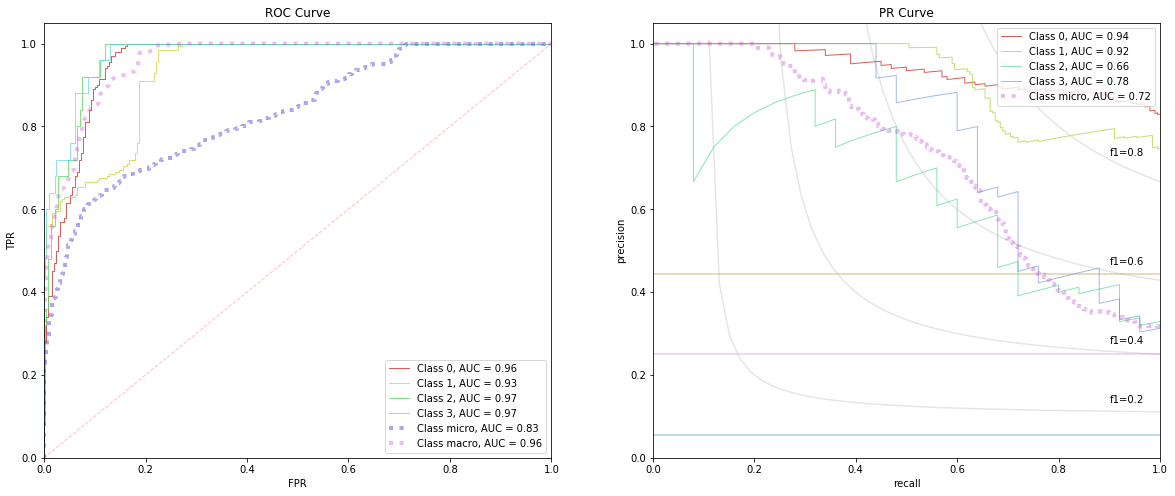

In [9]:
tpr, fpr, roc_auc, roc_keys = get_roc_stats(R)
precision, recall, average_precision, baselines, pr_keys = get_pr_stats(R)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_rocs(tpr, fpr, roc_auc, roc_keys, ax[0])
plot_prs(precision, recall, average_precision, baselines, pr_keys, ax[1])

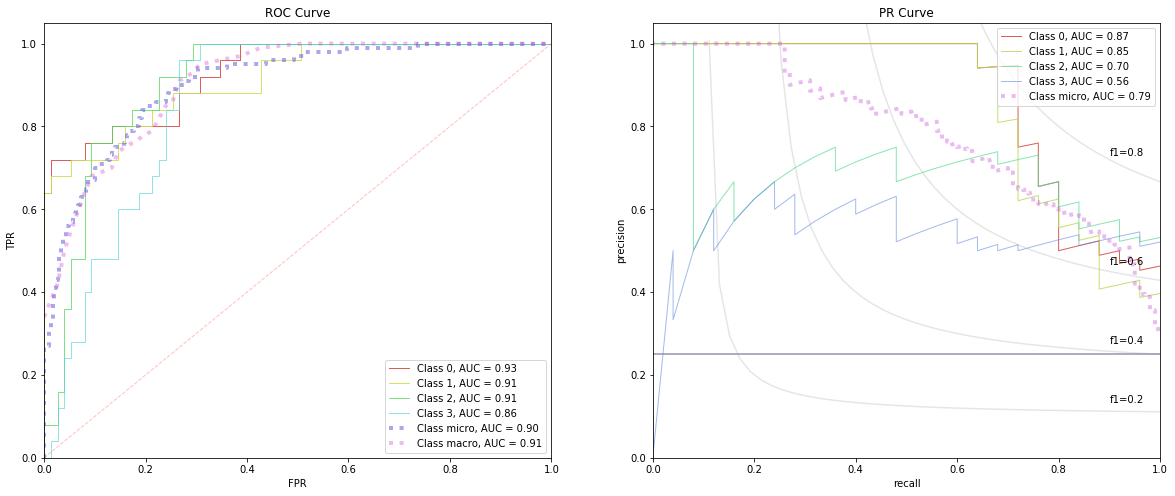

In [10]:
tpr, fpr, roc_auc, roc_keys = get_roc_stats(E)
precision, recall, average_precision, baselines, pr_keys = get_pr_stats(E)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_rocs(tpr, fpr, roc_auc, roc_keys, ax[0])
plot_prs(precision, recall, average_precision, baselines, pr_keys, ax[1])

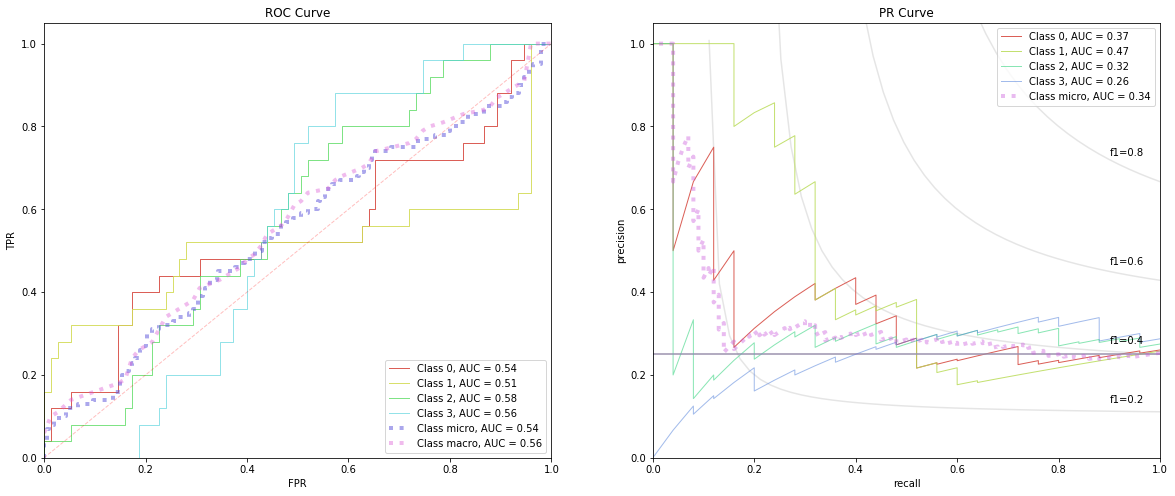

In [11]:
tpr, fpr, roc_auc, roc_keys = get_roc_stats(V)
precision, recall, average_precision, baselines, pr_keys = get_pr_stats(V)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_rocs(tpr, fpr, roc_auc, roc_keys, ax[0])
plot_prs(precision, recall, average_precision, baselines, pr_keys, ax[1])